In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.decomposition import NMF
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd
import ensemble as nmf

os.sys.path.append("C:\\Users\\mplitt\\MightyMorphingPhotonRangers\\CensoredLstsq")
os.sys.path.append("")

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
mouse = '4222153.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')|
                   df_mouse['Track'].str.match('TwoTower_foraging')]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [100]:
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.2\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...
1750,4222153.2,10_04_2019,2,TwoTower_foraging,0,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,None,None
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.2\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.2\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.2\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.2\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.2\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222153.2\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...


In [101]:
sess = df_mouse.iloc[-1]

In [102]:
VRDat,C, S, A = pp.load_scan_sess(sess)
Smean = np.mean(S,axis=0)
S /= Smean[np.newaxis,:]

num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [103]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds,bin_size=10)
S_flatmat = S_trial_mat.reshape([S_trial_mat.shape[0],-1])

In [104]:
print(S_flatmat.shape,S_trial_mat.shape)

(85, 87795) (85, 45, 1951)


In [105]:
trialmask = np.zeros([S_flatmat.shape[0]])
inds = np.random.permutation(S_flatmat.shape[0])
print(inds)
trialmask[inds[:int(S_flatmat.shape[0]/2)]]=1
print(trialmask)
trialmask = trialmask>0.


[24 13 18 74 49 81 75 55 54 64 45 33  6 30 25 21 20 32 14  5 34 26 62 51
 60 35 72 47 10 27 80 39  1 77 57 28  7 70 22 44 17 29 23 78 48  2 41 37
  9 11 16  4 63 66 59  3 68 82 42 53 50 67 46 19 56 73 12 52 58 31 71 79
 15 61 69 84  8 76 36 40 83 65 43  0 38]
[0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]


In [106]:
nmf_basic = NMF(n_components=2)
W = nmf_basic.fit_transform(S_flatmat[trialmask,:])

In [107]:
print(W.shape)

(42, 2)


In [108]:
H = nmf_basic.components_
print(H.shape)

(2, 87795)


In [109]:
What = np.matmul(S_flatmat[~trialmask,:],H.T)

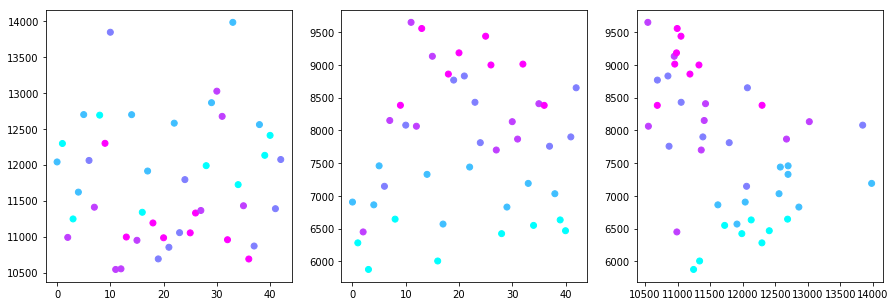

In [112]:
f,ax = plt.subplots(1,3,figsize=[15,5])
xarr = np.arange(What.shape[0])
ax[0].scatter(xarr,What[:,0],c=trial_info['morphs'][~trialmask],cmap='cool')
ax[1].scatter(xarr,What[:,1],c=trial_info['morphs'][~trialmask],cmap='cool')
ax[2].scatter(What[:,0],What[:,1],c=trial_info['morphs'][~trialmask],cmap='cool')
# f.savefig('discreteeg.pdf',format='pdf')

In [113]:

results = nmf.fit_ensemble(S_flatmat[trialmask,:],np.arange(1,11),n_replicates=5)








  0%|                                                                                           | 0/10 [00:00<?, ?it/s]






 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.23it/s]






 20%|████████████████▌                                                                  | 2/10 [00:04<00:13,  1.74s/it]






 30%|████████████████████████▉                                                          | 3/10 [00:11<00:22,  3.19s/it]






 40%|█████████████████████████████████▏                                                 | 4/10 [00:18<00:26,  4.49s/it]






 50%|█████████████████████████████████████████▌                                         | 5/10 [00:27<00:28,  5.75s/it]






 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:38<00:29,  7.44s/it]






 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:51<00:27,  9

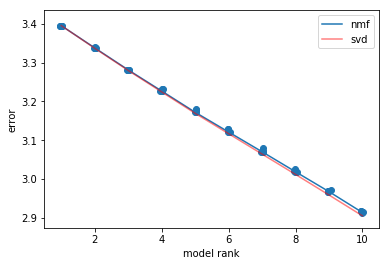

In [114]:
import plots 
plots.plot_rmse(results)

In [76]:
print(results.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


In [77]:
W,H = results[2]['factors'][0][0], results[2]['factors'][0][1]

In [78]:
print(W.shape,H.shape)

(120, 2) (2, 60300)


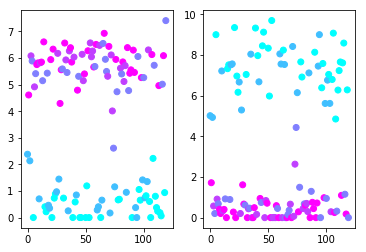

In [79]:
f,ax = plt.subplots(1,2)
xarr = np.arange(W.shape[0])
ax[0].scatter(xarr,W[:,0],c=trial_info['morphs'],cmap='cool')
ax[1].scatter(xarr,W[:,1],c=trial_info['morphs'],cmap='cool')

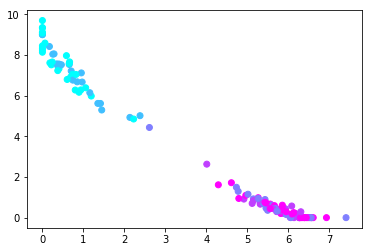

In [81]:
f,ax = plt.subplots()
ax.scatter(W[:,0],W[:,1],c=trial_info['morphs'],cmap='cool')

In [82]:
H_cells = H.reshape([2,S_trial_mat.shape[1],S_trial_mat.shape[2]])

In [83]:
print(H_cells.shape,S_trial_mat.shape)

(2, 45, 1340) (120, 45, 1340)


In [84]:
getSort = lambda fr : np.argsort(np.argmax(fr,axis=0),axis=0)


In [85]:
sort0,sort1 = getSort(H_cells[0,:,:]), getSort(H_cells[1,:,:])

In [86]:
print(sort0.shape)

(1340,)


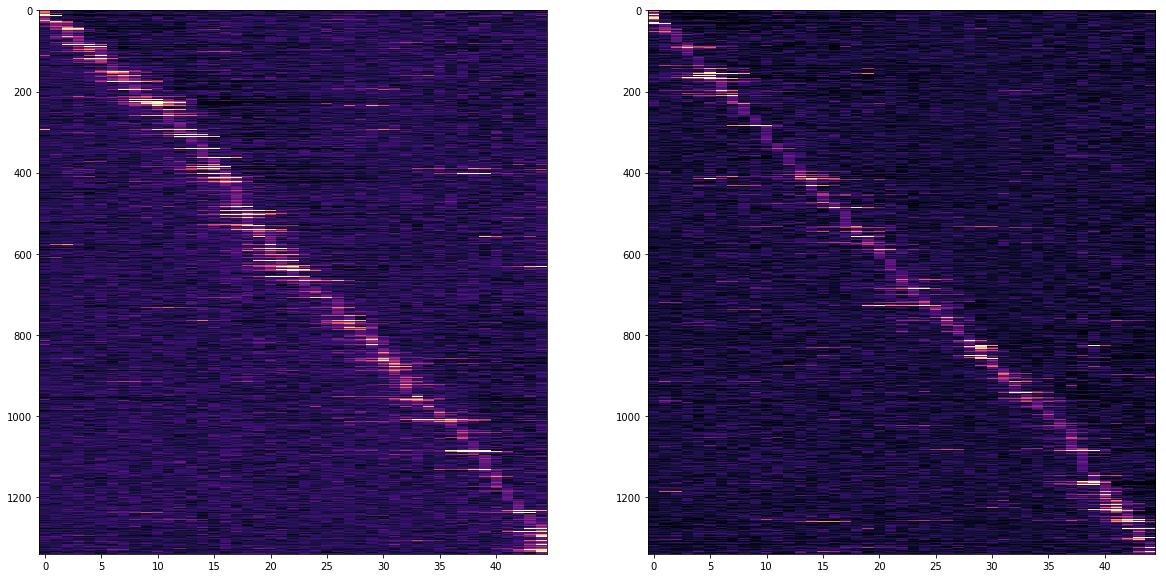

In [98]:
f,ax= plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(H_cells[0,:,sort0],cmap='magma',aspect='auto',vmax=1)
ax[1].imshow(H_cells[1,:,sort1],cmap='magma',aspect='auto',vmax=1)

In [95]:
print(np.amin(H_cells),np.amax(H_cells))

0.0 4.9424092420746035
